In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
PROCESSED_DIR = os.path.join(".", "processed")

df_mon = pd.read_csv(os.path.join(PROCESSED_DIR, "monday_clean.csv"))
df_tue = pd.read_csv(os.path.join(PROCESSED_DIR, "tuesday_clean.csv"))
df_fri = pd.read_csv(os.path.join(PROCESSED_DIR, "friday_clean.csv"))

print(df_mon.shape, df_tue.shape, df_fri.shape)


(529918, 70) (445909, 70) (225745, 70)


In [3]:
BASE_COLS = [
    "Destination Port",
    "Flow Bytes/s",
    "Flow Packets/s",
    "Flow Duration",
    "SYN Flag Count",
    "RST Flag Count",
    "FIN Flag Count",
]

for c in BASE_COLS:
    assert c in df_mon.columns, f"Missing column: {c}"

print("All required columns present ✅")


All required columns present ✅


In [4]:
baseline = {}

def q(series, p):
    return float(series.quantile(p))

baseline["bytes_p95"] = q(df_mon["Flow Bytes/s"], 0.95)
baseline["bytes_p99"] = q(df_mon["Flow Bytes/s"], 0.99)

baseline["pkts_p95"]  = q(df_mon["Flow Packets/s"], 0.95)
baseline["pkts_p99"]  = q(df_mon["Flow Packets/s"], 0.99)

baseline["dur_p99"]   = q(df_mon["Flow Duration"], 0.99)

baseline["flags_p99"] = q(
    (df_mon["SYN Flag Count"] + df_mon["RST Flag Count"] + df_mon["FIN Flag Count"]),
    0.99
)

baseline


{'bytes_p95': 4000000.0,
 'bytes_p99': 15500000.0,
 'pkts_p95': 666666.666666667,
 'pkts_p99': 1000000.0,
 'dur_p99': 117744477.75999999,
 'flags_p99': 1.0}

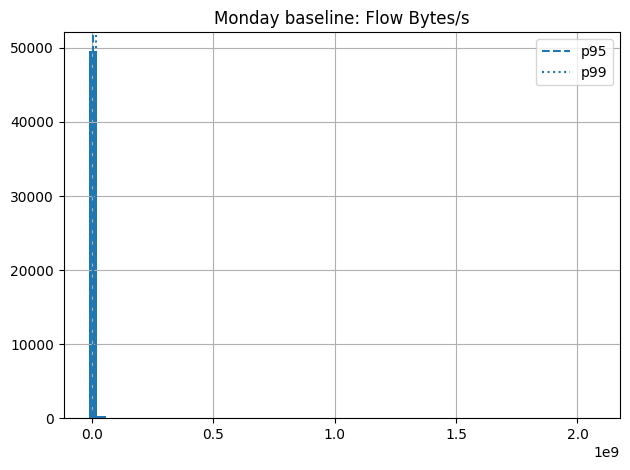

In [10]:
plt.figure()
df_mon["Flow Bytes/s"].sample(50000, random_state=42).hist(bins=60)
plt.axvline(baseline["bytes_p95"], linestyle="--", label="p95")
plt.axvline(baseline["bytes_p99"], linestyle=":", label="p99")
plt.title("Monday baseline: Flow Bytes/s")
plt.legend()
plt.tight_layout()
plt.show()


In [11]:
def apply_protect_rules(df: pd.DataFrame, base: dict) -> pd.DataFrame:
    out = df.copy()

    flag_sum = (
        out["SYN Flag Count"] +
        out["RST Flag Count"] +
        out["FIN Flag Count"]
    )

    out["viol_high_bytes"] = (out["Flow Bytes/s"]   > base["bytes_p99"]).astype(int)
    out["viol_high_pkts"]  = (out["Flow Packets/s"] > base["pkts_p99"]).astype(int)
    out["viol_long_flow"]  = (out["Flow Duration"]  > base["dur_p99"]).astype(int)
    out["viol_flags"]      = (flag_sum              > base["flags_p99"]).astype(int)

    out["viol_any"] = (
        out["viol_high_bytes"] |
        out["viol_high_pkts"]  |
        out["viol_long_flow"]  |
        out["viol_flags"]
    ).astype(int)

    return out


In [12]:
prot_tue = apply_protect_rules(df_tue, baseline)
prot_fri = apply_protect_rules(df_fri, baseline)

print("Tuesday violation %:", round(prot_tue["viol_any"].mean()*100, 3))
print("Friday  violation %:", round(prot_fri["viol_any"].mean()*100, 3))


Tuesday violation %: 2.767
Friday  violation %: 0.817


In [13]:
def viol_breakdown(df: pd.DataFrame) -> pd.Series:
    return pd.Series({
        "high_bytes_%": round(df["viol_high_bytes"].mean()*100, 3),
        "high_pkts_%":  round(df["viol_high_pkts"].mean()*100, 3),
        "long_flow_%":  round(df["viol_long_flow"].mean()*100, 3),
        "flags_%":      round(df["viol_flags"].mean()*100, 3),
        "any_%":        round(df["viol_any"].mean()*100, 3),
    })

bd = pd.DataFrame({
    "tuesday": viol_breakdown(prot_tue),
    "friday":  viol_breakdown(prot_fri),
})
bd


,tuesday,friday
high_bytes_%,0.894,0.309
high_pkts_%,0.876,0.214
long_flow_%,1.304,0.380
flags_%,0.000,0.000
any_%,2.767,0.817


In [14]:
def port_violation_table(df: pd.DataFrame, top_n=20):
    g = df.groupby("Destination Port", as_index=False).agg(
        flows=("Destination Port", "size"),
        viol_any=("viol_any", "mean"),
        viol_bytes=("viol_high_bytes", "mean"),
        viol_pkts=("viol_high_pkts", "mean"),
        viol_flags=("viol_flags", "mean"),
    )
    for c in ["viol_any","viol_bytes","viol_pkts","viol_flags"]:
        g[c] = (g[c]*100).round(3)
    return g.sort_values("viol_any", ascending=False).head(top_n)

top_ports_tue = port_violation_table(prot_tue)
top_ports_fri = port_violation_table(prot_fri)

top_ports_tue, top_ports_fri


(       Destination Port  flows  viol_any  viol_bytes  viol_pkts  viol_flags
 16606             48594      1     100.0       100.0        0.0         0.0
 11416             38712      1     100.0         0.0      100.0         0.0
 6174              10266      1     100.0       100.0      100.0         0.0
 6181              10273      1     100.0       100.0      100.0         0.0
 6182              10274      1     100.0       100.0      100.0         0.0
 6188              10280      1     100.0       100.0      100.0         0.0
 6200              10292      1     100.0       100.0      100.0         0.0
 636                2115      1     100.0       100.0        0.0         0.0
 30578             63062      1     100.0       100.0      100.0         0.0
 30579             63063      1     100.0       100.0      100.0         0.0
 6213              10311      1     100.0       100.0        0.0         0.0
 30581             63065      1     100.0       100.0      100.0         0.0

In [15]:
def viol_vs_attack(df: pd.DataFrame):
    return pd.crosstab(df["viol_any"], df["is_attack"], normalize="index") * 100

viol_vs_attack(prot_tue), viol_vs_attack(prot_fri)


(is_attack          0         1
 viol_any                      
 0          96.833261  3.166739
 1          99.149109  0.850891,
 is_attack          0          1
 viol_any                       
 0          42.833216  57.166784
 1          98.373102   1.626898)

In [16]:
OUT_DIR = os.path.join(".", "outputs")
os.makedirs(OUT_DIR, exist_ok=True)

prot_tue.to_csv(os.path.join(OUT_DIR, "protect_tuesday_violations.csv"), index=False)
prot_fri.to_csv(os.path.join(OUT_DIR, "protect_friday_violations.csv"), index=False)
top_ports_tue.to_csv(os.path.join(OUT_DIR, "protect_top_ports_tuesday.csv"), index=False)
top_ports_fri.to_csv(os.path.join(OUT_DIR, "protect_top_ports_friday.csv"), index=False)

print("Saved PROTECT reports.")


Saved PROTECT reports.


In [18]:
explain = """
INTERPRETATION – PROTECT

• Normal behaviour baselines were derived using clean Monday traffic.
• Rule-based thresholds were applied to detect policy violations in later traffic.
• Only a small percentage of flows violated baseline thresholds, even on high-attack days.
• This shows that many attacks resemble normal traffic and highlights the limits of rule-based controls.
• The findings justify the need for anomaly detection in addition to protective policies.
""".strip()

print(explain)


INTERPRETATION – PROTECT

• Normal behaviour baselines were derived using clean Monday traffic.
• Rule-based thresholds were applied to detect policy violations in later traffic.
• Only a small percentage of flows violated baseline thresholds, even on high-attack days.
• This shows that many attacks resemble normal traffic and highlights the limits of rule-based controls.
• The findings justify the need for anomaly detection in addition to protective policies.
